In [1]:
import zipfile
import os

zip_path = "/content/hacettepe.zip"
extract_path = "/content/hacettepe"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)



In [2]:
!pip install SimpleITK nibabel pydicom


In [3]:
import SimpleITK as sitk
import nibabel as nib
import numpy as np
import shutil
import gzip


In [4]:
base_path = "/content/hacettepe"

all_masks_only = []   # tüm mask dosyaları buraya
all_images_only = []  # tüm image dosyaları buraya

def convert_dicom_to_nii(dicom_folder, output_path):
    try:
        reader = sitk.ImageSeriesReader()
        dicom_names = reader.GetGDCMSeriesFileNames(dicom_folder)
        if not dicom_names:
            return False
        reader.SetFileNames(dicom_names)
        image = reader.Execute()
        sitk.WriteImage(image, output_path)
        return True
    except Exception as e:
        print(f"❌ DICOM çevirme hatası: {e}")
        return False

def ensure_nii_gz_format(src_path, dst_path):
    if os.path.abspath(src_path) == os.path.abspath(dst_path):
        # Aynı dosyaya kopyalamaya çalışıyorsak, boşuna uğraşma
        return dst_path
    if src_path.endswith(".nii"):
        with open(src_path, 'rb') as f_in:
            with gzip.open(dst_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        return dst_path
    elif src_path.endswith(".nii.gz"):
        shutil.copy(src_path, dst_path)
        return dst_path
    return None



In [5]:
import os

for root, dirs, files in os.walk(base_path):
    dicom_files = [f for f in files if f.endswith(".dcm")]

    # DICOM klasörü varsa .nii.gz'ye cevirip kullan
    if dicom_files:
        output_nii = os.path.join(root, "image.nii.gz")
        if convert_dicom_to_nii(root, output_nii):
            all_images_only.append(output_nii)
            print(f"✅ DICOM → NIfTI dönüştürüldü: {output_nii}")
        continue

    for file in files:
        file_path = os.path.join(root, file)
        f_lower = file.lower()

        # Image dosyası
        if f_lower.endswith((".nii", ".nii.gz")) and ("t1" in f_lower or "kontras" in f_lower or "image" in f_lower):
            new_path = os.path.join(root, "image.nii.gz")
            new_image_path = ensure_nii_gz_format(file_path, new_path)
            if new_image_path:
                all_images_only.append(new_image_path)
                print(f"📥 Image alındı: {new_image_path}")

        # Mask dosyası
        elif f_lower.endswith((".nii", ".nii.gz")) and ("segment" in f_lower or "mask" in f_lower or "seg" in f_lower):
            new_path = os.path.join(root, "mask.nii.gz")
            new_mask_path = ensure_nii_gz_format(file_path, new_path)
            if new_mask_path:
                all_masks_only.append(new_mask_path)
                print(f"📥 Mask alındı: {new_mask_path}")


📥 Mask alındı: /content/hacettepe/HU AUTOSEG CNN/Tülay Elhan/mask.nii.gz
📥 Mask alındı: /content/hacettepe/HU AUTOSEG CNN/Tülay Elhan/mask.nii.gz
✅ DICOM → NIfTI dönüştürüldü: /content/hacettepe/HU AUTOSEG CNN/Tülay Elhan/c+ T1/image.nii.gz
📥 Mask alındı: /content/hacettepe/HU AUTOSEG CNN/Hatice Çınar/mask.nii.gz
📥 Image alındı: /content/hacettepe/HU AUTOSEG CNN/Hatice Çınar/image.nii.gz
📥 Image alındı: /content/hacettepe/HU AUTOSEG CNN/Hatice Çınar/image.nii.gz
📥 Mask alındı: /content/hacettepe/HU AUTOSEG CNN/Hatice Çınar/mask.nii.gz
📥 Mask alındı: /content/hacettepe/HU AUTOSEG CNN/emine bilgin/mask.nii.gz
📥 Mask alındı: /content/hacettepe/HU AUTOSEG CNN/emine bilgin/mask.nii.gz
📥 Image alındı: /content/hacettepe/HU AUTOSEG CNN/emine bilgin/image.nii.gz
📥 Image alındı: /content/hacettepe/HU AUTOSEG CNN/emine bilgin/image.nii.gz
📥 Mask alındı: /content/hacettepe/HU AUTOSEG CNN/Fatma Ceylan/mask.nii.gz
📥 Mask alındı: /content/hacettepe/HU AUTOSEG CNN/Fatma Ceylan/mask.nii.gz
📥 Image alı

In [6]:
print("\n📊 ÖZET")
print("Toplam görüntü (image):", len(all_images_only))
print("Toplam maske (mask):   ", len(all_masks_only))
print("Örnek image:", all_images_only[0] if all_images_only else "Bulunamadı")
print("Örnek mask :", all_masks_only[0] if all_masks_only else "Bulunamadı")



📊 ÖZET
Toplam görüntü (image): 16
Toplam maske (mask):    20
Örnek image: /content/hacettepe/HU AUTOSEG CNN/Tülay Elhan/c+ T1/image.nii.gz
Örnek mask : /content/hacettepe/HU AUTOSEG CNN/Tülay Elhan/mask.nii.gz


In [7]:
paired_X = []
paired_Y = []

for image_path in all_images_only:
    base_dir = os.path.dirname(image_path)
    mask_path = os.path.join(base_dir, "mask.nii.gz")

    if os.path.exists(mask_path):
        paired_X.append(image_path)
        paired_Y.append(mask_path)

print("🎯 Eğitim için eşleşmiş çift sayısı:", len(paired_X))
print("Örnek X:", paired_X[0])
print("Örnek Y:", paired_Y[0])


🎯 Eğitim için eşleşmiş çift sayısı: 12
Örnek X: /content/hacettepe/HU AUTOSEG CNN/Hatice Çınar/image.nii.gz
Örnek Y: /content/hacettepe/HU AUTOSEG CNN/Hatice Çınar/mask.nii.gz


In [8]:
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch


class BrainSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, target_shape=(128, 128, 128)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.target_shape = target_shape

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = nib.load(self.image_paths[idx]).get_fdata()
        mask = nib.load(self.mask_paths[idx]).get_fdata()

        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = np.expand_dims(image, axis=0)
        mask = np.expand_dims(mask, axis=0)

        # Tensor’a çevir
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)  # 🔧 float32 olması önemli!

        # Resize [C, D, H, W] → [1, 128, 128, 128]
        image = F.interpolate(image.unsqueeze(0), size=self.target_shape, mode='trilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0), size=self.target_shape, mode='nearest').squeeze(0)

        # Mask'i tekrar long yap çünkü loss fonksiyonu class label istiyor
        mask = mask.long()

        return image, mask


In [9]:
from sklearn.model_selection import train_test_split

# 75% eğitim, 25% doğrulama
X_train, X_val, y_train, y_val = train_test_split(
    paired_X, paired_Y, test_size=0.25, random_state=42
)

print("✅ Eğitim örnekleri:", len(X_train))
print("✅ Doğrulama örnekleri:", len(X_val))


✅ Eğitim örnekleri: 9
✅ Doğrulama örnekleri: 3


In [10]:
from torch.utils.data import DataLoader
import torch


# Dataset'leri oluştur
train_dataset = BrainSegDataset(X_train, y_train)
val_dataset = BrainSegDataset(X_val, y_val)

# DataLoader'ları oluştur
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Örnek kontrol herhangi bi batch al
train_sample = next(iter(train_loader))
print("Train batch image shape:", train_sample[0].shape)
print("Train batch mask shape :", train_sample[1].shape)


Train batch image shape: torch.Size([2, 1, 128, 128, 128])
Train batch mask shape : torch.Size([2, 1, 128, 128, 128])


In [11]:
import numpy as np
from collections import Counter

def compute_class_weights(mask_paths, num_classes=7):
    class_counts = Counter()

    for path in mask_paths:
        mask = nib.load(path).get_fdata().astype(np.int64)
        classes, counts = np.unique(mask, return_counts=True)
        for cls, count in zip(classes, counts):
            class_counts[cls] += count

    total_voxels = sum(class_counts.values())
    weights = []

    for i in range(num_classes):
        freq = class_counts[i] / total_voxels if i in class_counts else 0.0
        weight = 1.0 / (freq + 1e-6) if freq > 0 else 0.0
        weights.append(weight)

    weights = torch.tensor(weights, dtype=torch.float32)
    weights = torch.log1p(weights)  # log kullanarak daha dengeli ağırlık dağılımı
    weights = weights / weights.sum()

    return weights


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=7, init_features=64):
        super(UNet3D, self).__init__()
        features = init_features

        # Encoder
        self.encoder1 = self._block(in_channels, features)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.encoder2 = self._block(features, features * 2)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.encoder3 = self._block(features * 2, features * 4)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self._block(features * 4, features * 8)

        # Decoder
        self.up3 = nn.ConvTranspose3d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._block(features * 8, features * 4)

        self.up2 = nn.ConvTranspose3d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._block(features * 4, features * 2)

        self.up1 = nn.ConvTranspose3d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._block(features * 2, features)

        # Output
        self.output_layer = nn.Conv3d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))

        bottleneck = self.bottleneck(self.pool3(enc3))

        dec3 = self.up3(bottleneck)
        dec3 = self.decoder3(torch.cat((dec3, enc3), dim=1))

        dec2 = self.up2(dec3)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))

        dec1 = self.up1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))

        return self.output_layer(dec1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )


In [13]:
# gpu 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("📦 Cihaz:", device)

# Model
model = UNet3D(in_channels=1, out_channels=7)
model = model.to(device)

# dummy input ile test 
x = torch.randn(1, 1, 128, 128, 128).to(device)
y = model(x)

print("✅ Model output shape:", y.shape)  # [1, 7, 128, 128, 128]
print("🎯 Output sınıf dağılımı (örnek):", torch.argmax(y, dim=1).unique())


📦 Cihaz: cuda
✅ Model output shape: torch.Size([1, 7, 128, 128, 128])
🎯 Output sınıf dağılımı (örnek): tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


In [14]:
import torch.optim as optim
import torch.nn as nn

# 🔹 Weighted CrossEntropyLoss
class_weights = compute_class_weights(y_train)
ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))


In [15]:
def dice_score(preds, targets, num_classes=7, eps=1e-6):
    dices = []
    preds = torch.argmax(preds, dim=1)

    for cls in range(1, num_classes):
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()

        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice = (2. * intersection + eps) / (union + eps)
        dices.append((cls, dice.item()))

    return dices

def dice_loss(preds, targets, num_classes=7, eps=1e-6):
    preds = F.softmax(preds, dim=1)
    targets_onehot = F.one_hot(targets, num_classes=num_classes).permute(0, 4, 1, 2, 3).float()

    dice = 0
    for cls in range(1, num_classes):  # class 0 (background) hariç
        pred_cls = preds[:, cls]
        target_cls = targets_onehot[:, cls]

        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice += (2. * intersection + eps) / (union + eps)

    return 1 - (dice / (num_classes - 1))

# 🔹 Combined loss fonksiyonu (CE + Dice)
def combined_loss(preds, targets):
    ce = ce_loss_fn(preds, targets)
    dl = dice_loss(preds, targets)
    return ce + dl

# 🔹 Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [16]:
import gc
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True).squeeze(1).long()

        outputs = model(images)
        loss = combined_loss(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Bellek temizliği
        del images, masks, outputs, loss
        torch.cuda.empty_cache()
        gc.collect()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    dice_total = 0.0
    dice_count = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True).squeeze(1).long()

            outputs = model(images)
            loss = combined_loss(outputs, masks)

            val_loss += loss.item()

            dice_scores = dice_score(outputs, masks)
            for cls, d in dice_scores:
                print(f"      🔸 Class {cls} Dice: {d:.4f}")
                dice_total += d
                dice_count += 1

            # Bellek temizliği
            del images, masks, outputs, loss
            torch.cuda.empty_cache()
            gc.collect()

    avg_val_loss = val_loss / len(val_loader)
    avg_dice = dice_total / dice_count if dice_count > 0 else 0.0

    print(f"\n📘 Epoch [{epoch+1}/{num_epochs}]")
    print(f"   🔹 Train Loss: {avg_train_loss:.4f}")
    print(f"   🔹 Val Loss  : {avg_val_loss:.4f}")
    print(f"   🔹 Avg Dice  : {avg_dice:.4f}\n")


      🔸 Class 1 Dice: 0.0049
      🔸 Class 2 Dice: 0.0000
      🔸 Class 3 Dice: 0.0000
      🔸 Class 4 Dice: 0.0000
      🔸 Class 5 Dice: 0.0000
      🔸 Class 6 Dice: 0.0000
      🔸 Class 1 Dice: 0.0086
      🔸 Class 2 Dice: 0.0000
      🔸 Class 3 Dice: 0.0000
      🔸 Class 4 Dice: 0.0000
      🔸 Class 5 Dice: 0.0000
      🔸 Class 6 Dice: 0.0000

📘 Epoch [1/30]
   🔹 Train Loss: 2.6050
   🔹 Val Loss  : 2.9235
   🔹 Avg Dice  : 0.0011

      🔸 Class 1 Dice: 0.0113
      🔸 Class 2 Dice: 0.0000
      🔸 Class 3 Dice: 0.1868
      🔸 Class 4 Dice: 0.0000
      🔸 Class 5 Dice: 0.0107
      🔸 Class 6 Dice: 0.0000
      🔸 Class 1 Dice: 0.0286
      🔸 Class 2 Dice: 0.0000
      🔸 Class 3 Dice: 0.2123
      🔸 Class 4 Dice: 0.0000
      🔸 Class 5 Dice: 0.0024
      🔸 Class 6 Dice: 0.0000

📘 Epoch [2/30]
   🔹 Train Loss: 2.1875
   🔹 Val Loss  : 2.8596
   🔹 Avg Dice  : 0.0377

      🔸 Class 1 Dice: 0.0003
      🔸 Class 2 Dice: 0.0000
      🔸 Class 3 Dice: 0.4608
      🔸 Class 4 Dice: 0.0002
      🔸 Cl

In [17]:
torch.save(model.state_dict(), "unet3d_model_v2.pth")


In [18]:
model = UNet3D(in_channels=1, out_channels=7)
model.load_state_dict(torch.load("unet3d_model_v2.pth"))
model = model.to(device)
model.eval()


UNet3D(
  (encoder1): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool3d(kernel_size=2, st

In [19]:
import matplotlib.pyplot as plt
import numpy as np

test_image_path = paired_X[0]
test_mask_path = paired_Y[0]

image = nib.load(test_image_path).get_fdata()
image = (image - np.min(image)) / (np.max(image) - np.min(image))
image = np.expand_dims(image, axis=0)  # [1, D, H, W]
image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)  # [1, 1, D, H, W]

# Model çıktısı
with torch.no_grad():
    output = model(image_tensor)
    prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # [D, H, W]


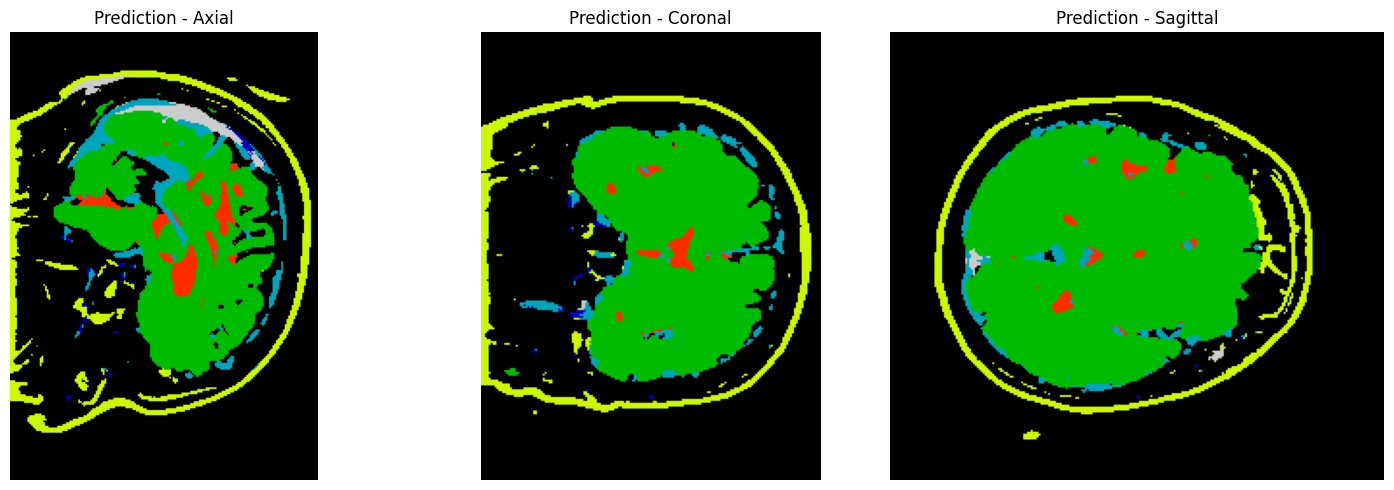

In [20]:
def plot_slices(pred, title="Prediction", num_slices=3):
    d, h, w = pred.shape
    fig, axs = plt.subplots(1, num_slices, figsize=(15, 5))
    slice_indices = [d//2, h//2, w//2]

    axs[0].imshow(pred[slice_indices[0], :, :], cmap="nipy_spectral")
    axs[0].set_title(f"{title} - Axial")

    axs[1].imshow(pred[:, slice_indices[1], :], cmap="nipy_spectral")
    axs[1].set_title(f"{title} - Coronal")

    axs[2].imshow(pred[:, :, slice_indices[2]], cmap="nipy_spectral")
    axs[2].set_title(f"{title} - Sagittal")

    for ax in axs: ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_slices(prediction)


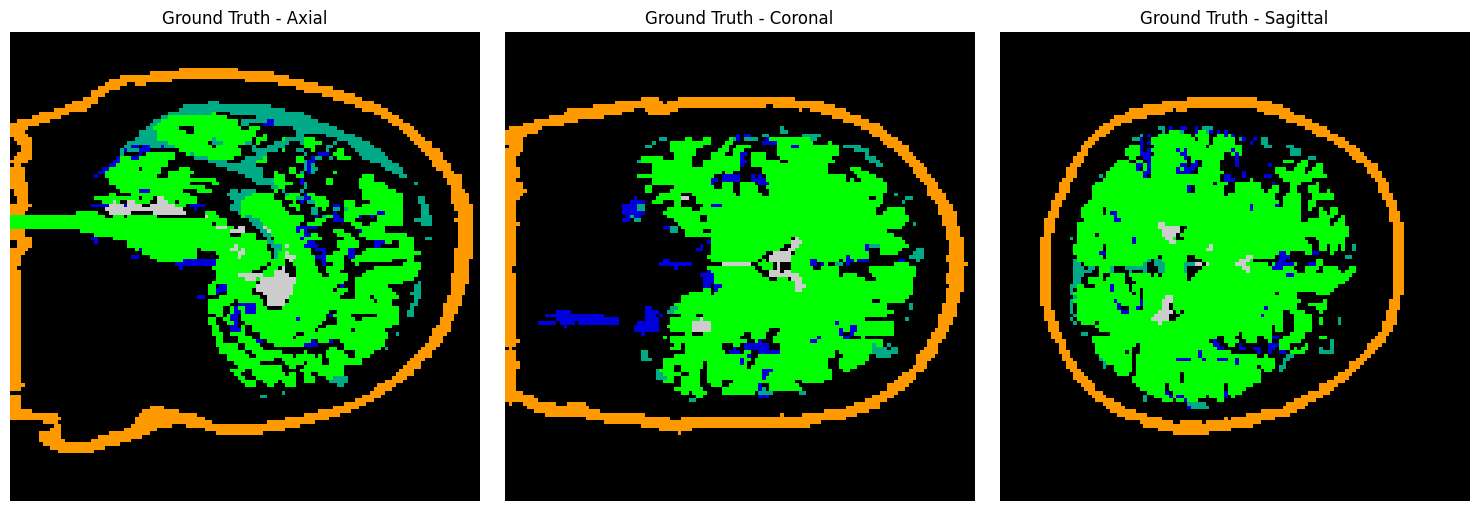

In [21]:
gt = nib.load(test_mask_path).get_fdata().astype(np.int64)
gt = F.interpolate(torch.tensor(gt[None, None, ...], dtype=torch.float32), size=(128, 128, 128), mode="nearest").squeeze().numpy()
plot_slices(gt, title="Ground Truth")
